In [74]:
import datetime
from itertools import combinations
from typing import NamedTuple
from matplotlib import pyplot as plot
from git import Repo
import networkx as nx
from pprint import pprint


In [75]:
repo = Repo("../quizzology")

In [76]:
repo_graph = nx.Graph()
for commit in repo.iter_commits():
    for (left,right) in combinations(commit.stats.files,2):
        if (left,right) in repo_graph.edges:
            data = repo_graph.get_edge_data(left,right)
            data['count'] = data.get('count',1) + 1
        else:
            repo_graph.add_edge(left,right)


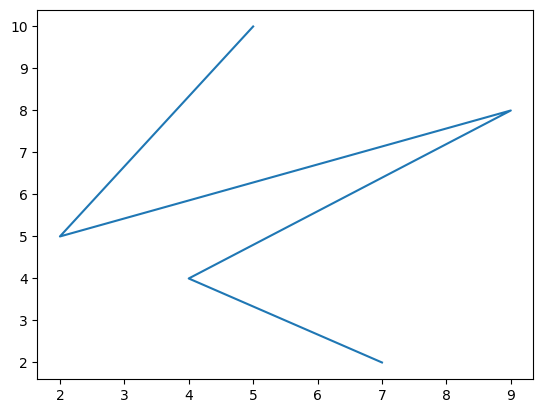

In [77]:
# Create a plot 

x = [5, 2, 9, 4, 7]
y = [10, 5, 8, 4, 2]
plot.plot(x, y)
plot.show()

In [78]:
# Draw a network plot of some kind

# graph = nx.petersen_graph() # well known sample data 
# subax = plot.subplot(121)
# nx.draw(graph)

# repo_plot = plot.subplot(122)
# nx.draw(repo_graph, with_labels=True)



In [79]:

pprint(list(nx.connected_components(repo_graph)))


[{'.dockerignore',
  '.github/workflows/quizzology-ci.yml',
  '.gitignore',
  '.pylintrc',
  'Dockerfile',
  'README.md',
  'TestDockerfile',
  'apps/__init__.py',
  'apps/author.py',
  'apps/author/__init__.py',
  'apps/author/author.py',
  'apps/author/author_controller.py',
  'apps/author/tests/__init__.py',
  'apps/author/tests/test_authorcontroller.py',
  'apps/author/tests/test_controller.py',
  'apps/author/tests/test_quiz_authoring_form.py',
  'apps/author/tests/test_quiz_schema.py',
  'apps/author/views/quiz_author_home.tpl',
  'apps/author/views/quiz_authoring_form.tpl',
  'apps/authoring/__init__.py',
  'apps/authoring/author.py',
  'apps/authoring/views/quiz_authoring_form.tpl',
  'apps/study.py',
  'apps/study/__init__.py',
  'apps/study/session_store.py',
  'apps/study/session_store_mongodb.py',
  'apps/study/session_store_tinydb.py',
  'apps/study/study.py',
  'apps/study/studycontroller.py',
  'apps/study/tests/__init__.py',
  'apps/study/tests/test_quiz_question.py',
 

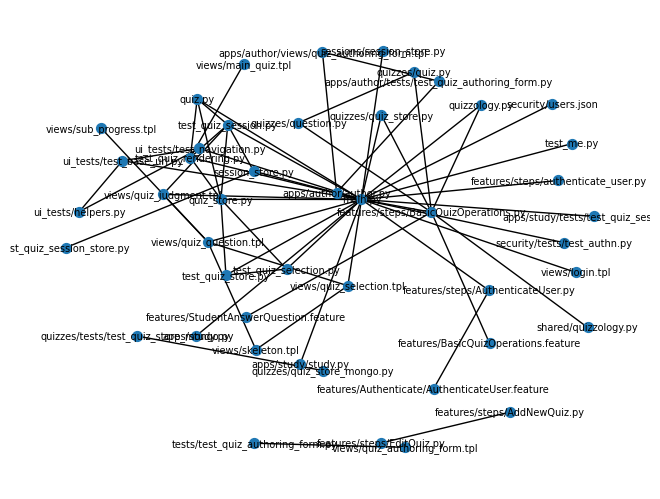

In [80]:
# Perhaps we should trim the data set so that we don't plot every single 
# edge and node in one ugly graph.

busiest_graph = nx.Graph()
busiest_graph.add_edges_from(edge 
                             for edge in repo_graph.edges 
                             if repo_graph.get_edge_data(*edge).get('count',0) > 5)
from networkx import spring_layout 
layout= spring_layout(busiest_graph, k=0.8, iterations=50)

nx.draw(busiest_graph, layout, with_labels=True, font_size=7, node_size=50)


    
    

In [81]:
help(nx.draw)


Help on function draw in module networkx.drawing.nx_pylab:

draw(G, pos=None, ax=None, **kwds)
    Draw the graph G with Matplotlib.
    
    Draw the graph as a simple representation with no node
    labels or edge labels and using the full Matplotlib figure area
    and no axis labels by default.  See draw_networkx() for more
    full-featured drawing that allows title, axis labels etc.
    
    Parameters
    ----------
    G : graph
        A networkx graph
    
    pos : dictionary, optional
        A dictionary with nodes as keys and positions as values.
        If not specified a spring layout positioning will be computed.
        See :py:mod:`networkx.drawing.layout` for functions that
        compute node positions.
    
    ax : Matplotlib Axes object, optional
        Draw the graph in specified Matplotlib axes.
    
    kwds : optional keywords
        See networkx.draw_networkx() for a description of optional keywords.
    
    Examples
    --------
    >>> G = nx.dodecahe

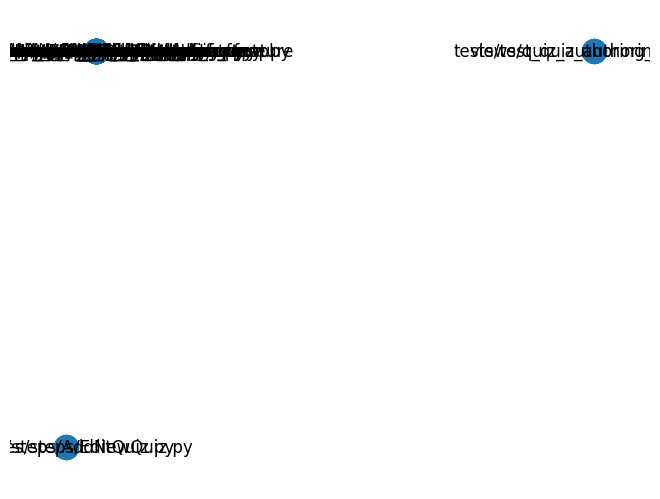

In [82]:
nx.draw_spectral(busiest_graph, with_labels=True)


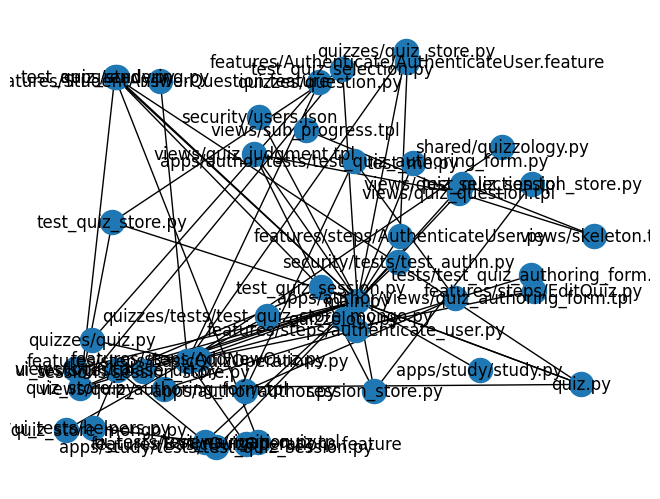

In [83]:
nx.draw_random(busiest_graph, with_labels=True)


Interesting ideas
* Average commit size
* Tests included in commits?
* Connected groups
* Most edited files
* Commit frequency
* Defects vs Features vs Refactors vs Other (conventional commits?)
* Ticket numbers and clustering of same

In [84]:
# Average commit size
repo = Repo('../quizzology')
commits = [(commit.author.name, commit.authored_datetime, len(commit.stats.files))
           for commit 
           in repo.iter_commits()
          ]
pprint(commits[:10])

[('Tim Ottinger',
  datetime.datetime(2022, 10, 18, 14, 19, 4, tzinfo=<git.objects.util.tzoffset object at 0x127055910>),
  1),
 ('Perry Reid',
  datetime.datetime(2022, 9, 14, 8, 58, 33, tzinfo=<git.objects.util.tzoffset object at 0x1273608d0>),
  2),
 ('Perry Reid',
  datetime.datetime(2022, 9, 13, 8, 52, 54, tzinfo=<git.objects.util.tzoffset object at 0x1271ce550>),
  3),
 ('Perry Reid',
  datetime.datetime(2022, 9, 13, 8, 29, 14, tzinfo=<git.objects.util.tzoffset object at 0x1271b4290>),
  3),
 ('Tim Ottinger',
  datetime.datetime(2022, 9, 9, 15, 5, 26, tzinfo=<git.objects.util.tzoffset object at 0x1270517d0>),
  2),
 ('Tim Ottinger',
  datetime.datetime(2022, 9, 8, 16, 34, 55, tzinfo=<git.objects.util.tzoffset object at 0x117db2c10>),
  14),
 ('Tim Ottinger',
  datetime.datetime(2022, 9, 8, 15, 0, 24, tzinfo=<git.objects.util.tzoffset object at 0x127261390>),
  3),
 ('Tim Ottinger',
  datetime.datetime(2022, 9, 8, 14, 2, 5, tzinfo=<git.objects.util.tzoffset object at 0x1272628d0>)

In [85]:
from statistics import mean, stdev, variance, multimode
counters = [ x for (_,_,x) in commits ]

print(f'Largest commit is {max(counters)} files')
print(f'Average commit is {mean(counters)} files')
print(f'Standard Deviation is {stdev(counters)}')
print(f'Variance is {variance(counters)}')
print(f'Multimode is {multimode(counters)}')

Largest commit is 30 files
Average commit is 2.3156532988357053 files
Standard Deviation is 2.222407261300911
Variance is 4.9390940350830155
Multimode is [1]


In [118]:
from datetime import datetime, timedelta
first_date = commits[0][1]
print(dir(first_date))
now = datetime.today()
print(f'Since {(now - timedelta(days=90)).isoformat()} ')
past90 = [ count for (author,timestamp,count)
           in commits
           if (now - timestamp).days < 91  ]
print(f'Largest commit is {max(counters)} files')
print(f'Average commit is {mean(counters)} files')
print(f'Standard Deviation is {stdev(counters)}')
print(f'Variance is {variance(counters)}')
print(f'Multimode is {multimode(counters)}')

['__add__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__rsub__', '__setattr__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', 'astimezone', 'combine', 'ctime', 'date', 'day', 'dst', 'fold', 'fromisocalendar', 'fromisoformat', 'fromordinal', 'fromtimestamp', 'hour', 'isocalendar', 'isoformat', 'isoweekday', 'max', 'microsecond', 'min', 'minute', 'month', 'now', 'replace', 'resolution', 'second', 'strftime', 'strptime', 'time', 'timestamp', 'timetuple', 'timetz', 'today', 'toordinal', 'tzinfo', 'tzname', 'utcfromtimestamp', 'utcnow', 'utcoffset', 'utctimetuple', 'weekday', 'year']
Since 2023-01-05T16:48:54.883892 


TypeError: can't subtract offset-naive and offset-aware datetimes